Name!

## 1. Import and display audio files

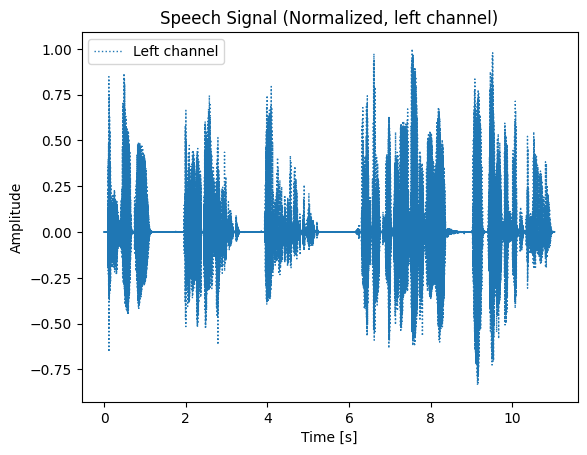

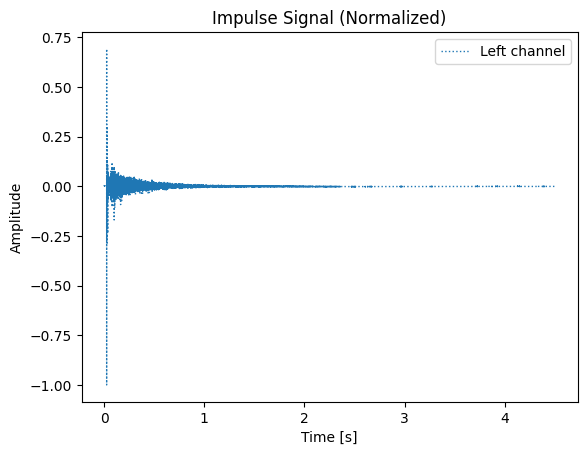

In [37]:
import os
from pathlib import Path
import scipy as sp
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

path_folder = Path.cwd()
path_speech = path_folder / 'speech.wav' 
path_impuls = path_folder / 'impulse_response.wav'
x = sp.io.wavfile.read(path_speech)
h = sp.io.wavfile.read(path_impuls)
sr_x, data_x = sp.io.wavfile.read(path_speech)
sr_h, data_h = sp.io.wavfile.read(path_impuls)

length_x = data_x.shape[0] / sr_x
length_h = data_h.shape[0] / sr_h


time_x = np.linspace(0., length_x, data_x.shape[0])
max_amp_x = np.max(np.abs(data_x[:, 0])) # Normalize based on left channel
plt.plot(time_x, data_x[:, 0] / max_amp_x, label="Left channel",linestyle=':', linewidth=1)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Speech Signal (Normalized, left channel)")
plt.show()


time_h = np.linspace(0., length_h, data_h.shape[0])
max_amp_h = np.max(np.abs(data_h)) # Normalize based on left channel
plt.plot(time_h, data_h / max_amp_h, label="Left channel",linestyle=':', linewidth=1)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Impulse Signal (Normalized)")
plt.show()

## 2. System properties

![WhatsApp Bild 2025-11-15 um 15.14.20_8b7c4e99.jpg](<attachment:WhatsApp Bild 2025-11-15 um 15.14.20_8b7c4e99.jpg>)
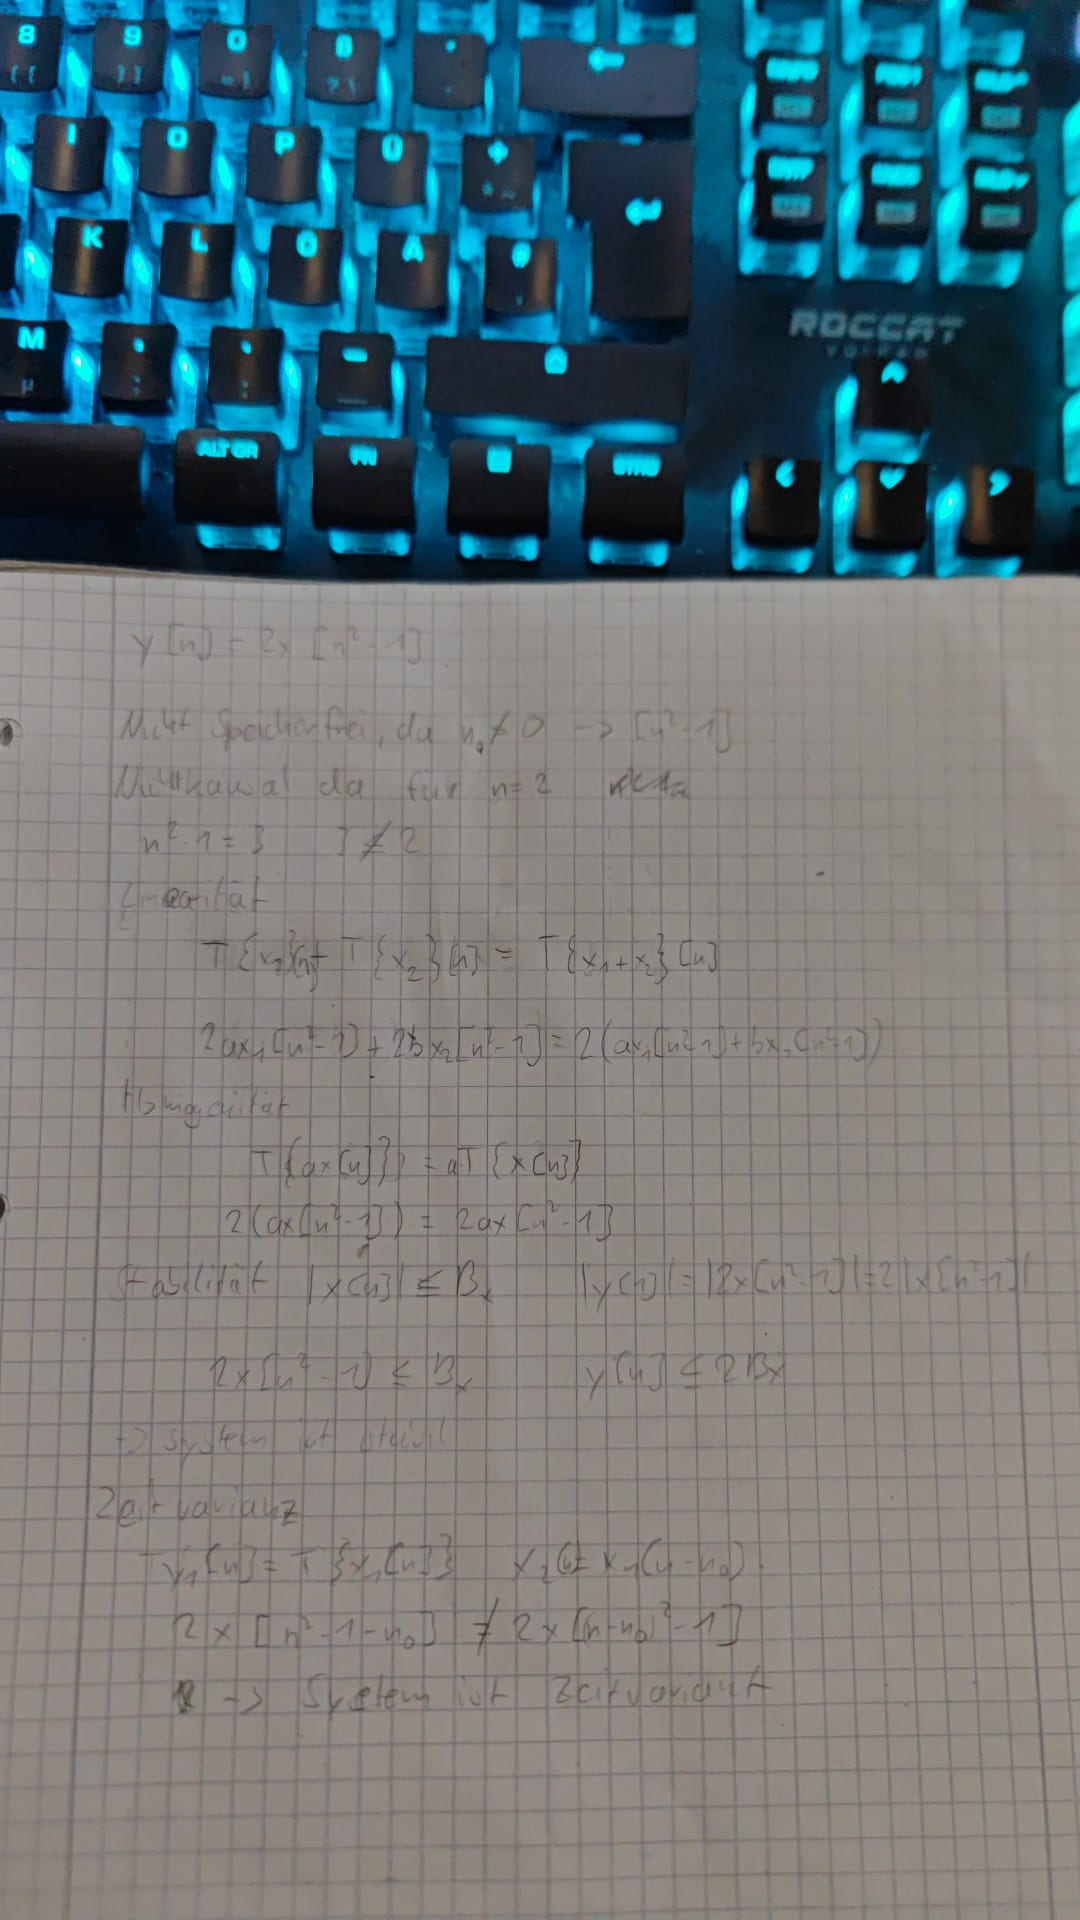

![WhatsApp Bild 2025-11-15 um 15.40.08_97907a2a.jpg](<attachment:WhatsApp Bild 2025-11-15 um 15.40.08_97907a2a.jpg>)
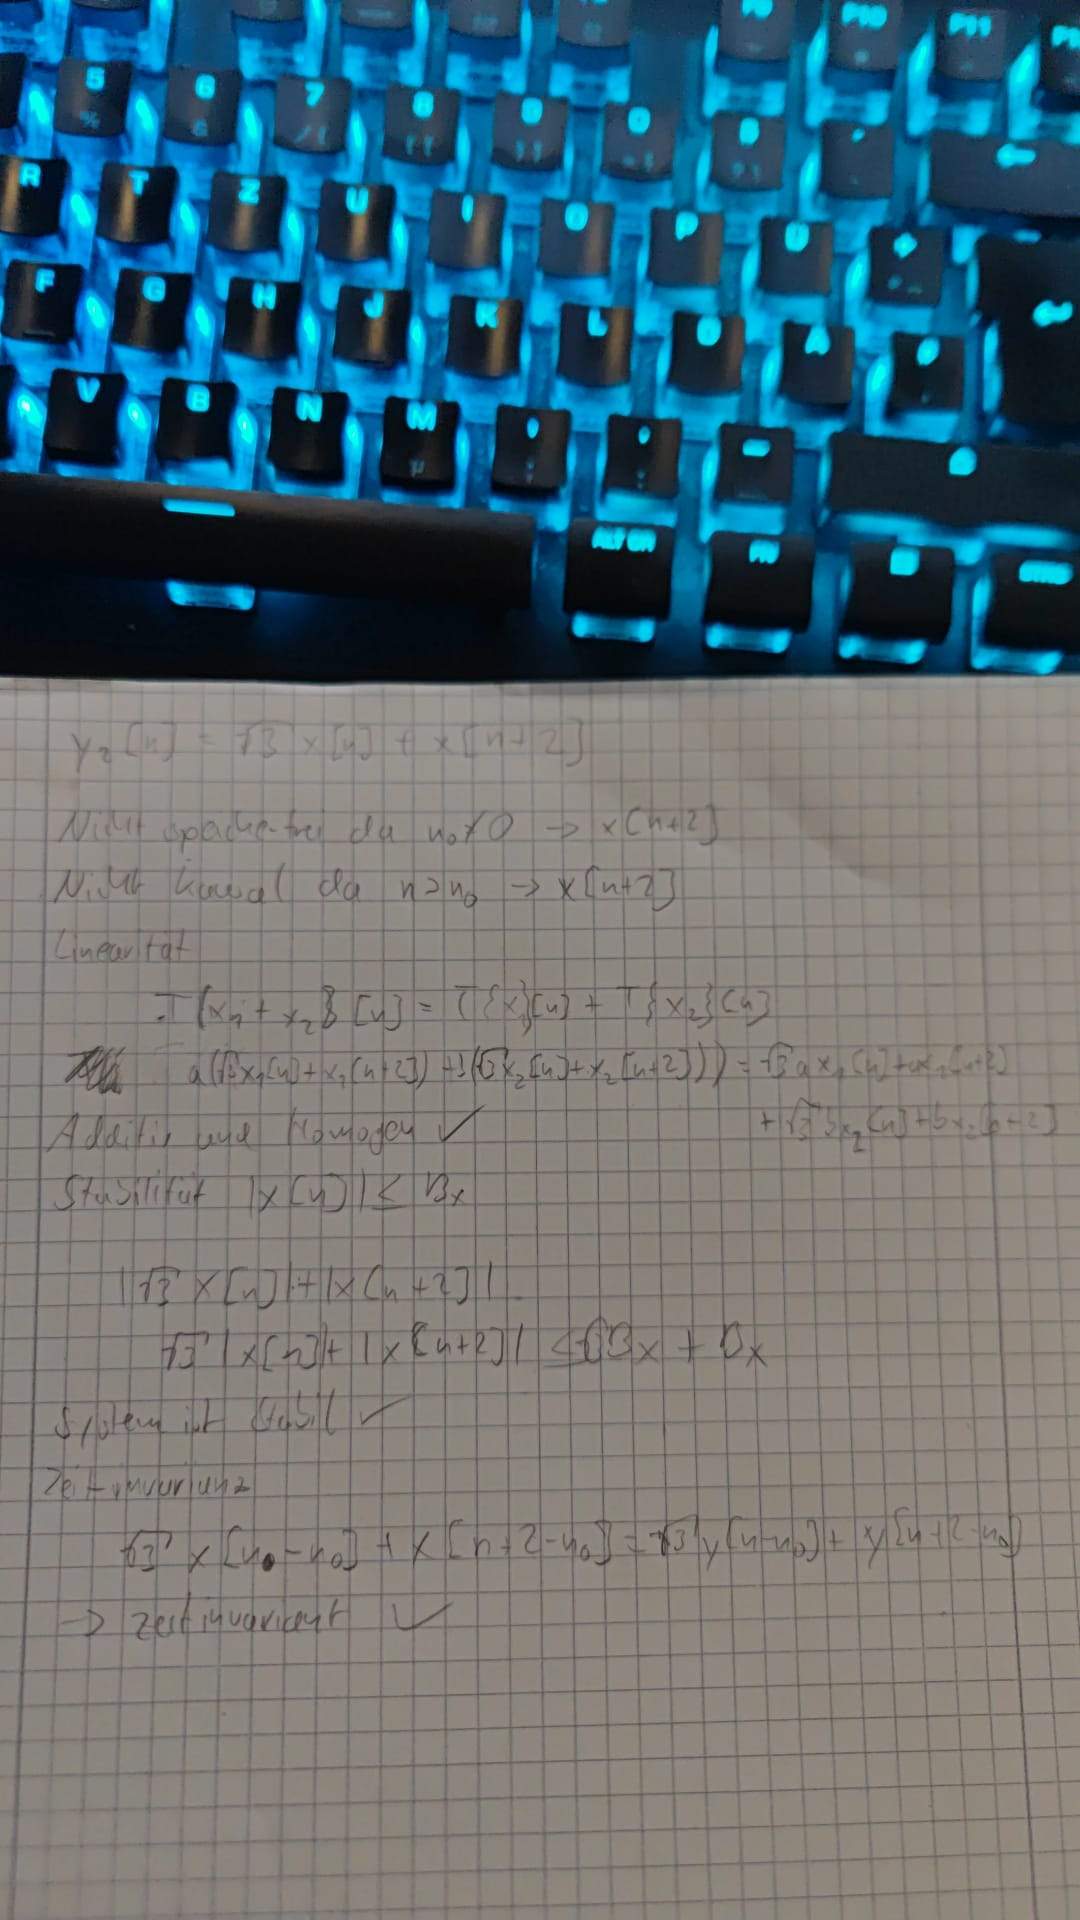

## 3. Convlution

### a)
![WhatsApp Bild 2025-11-23 um 17.41.13_2d06d9cf.jpg](<attachment:WhatsApp Bild 2025-11-23 um 17.41.13_2d06d9cf.jpg>)

### b) 
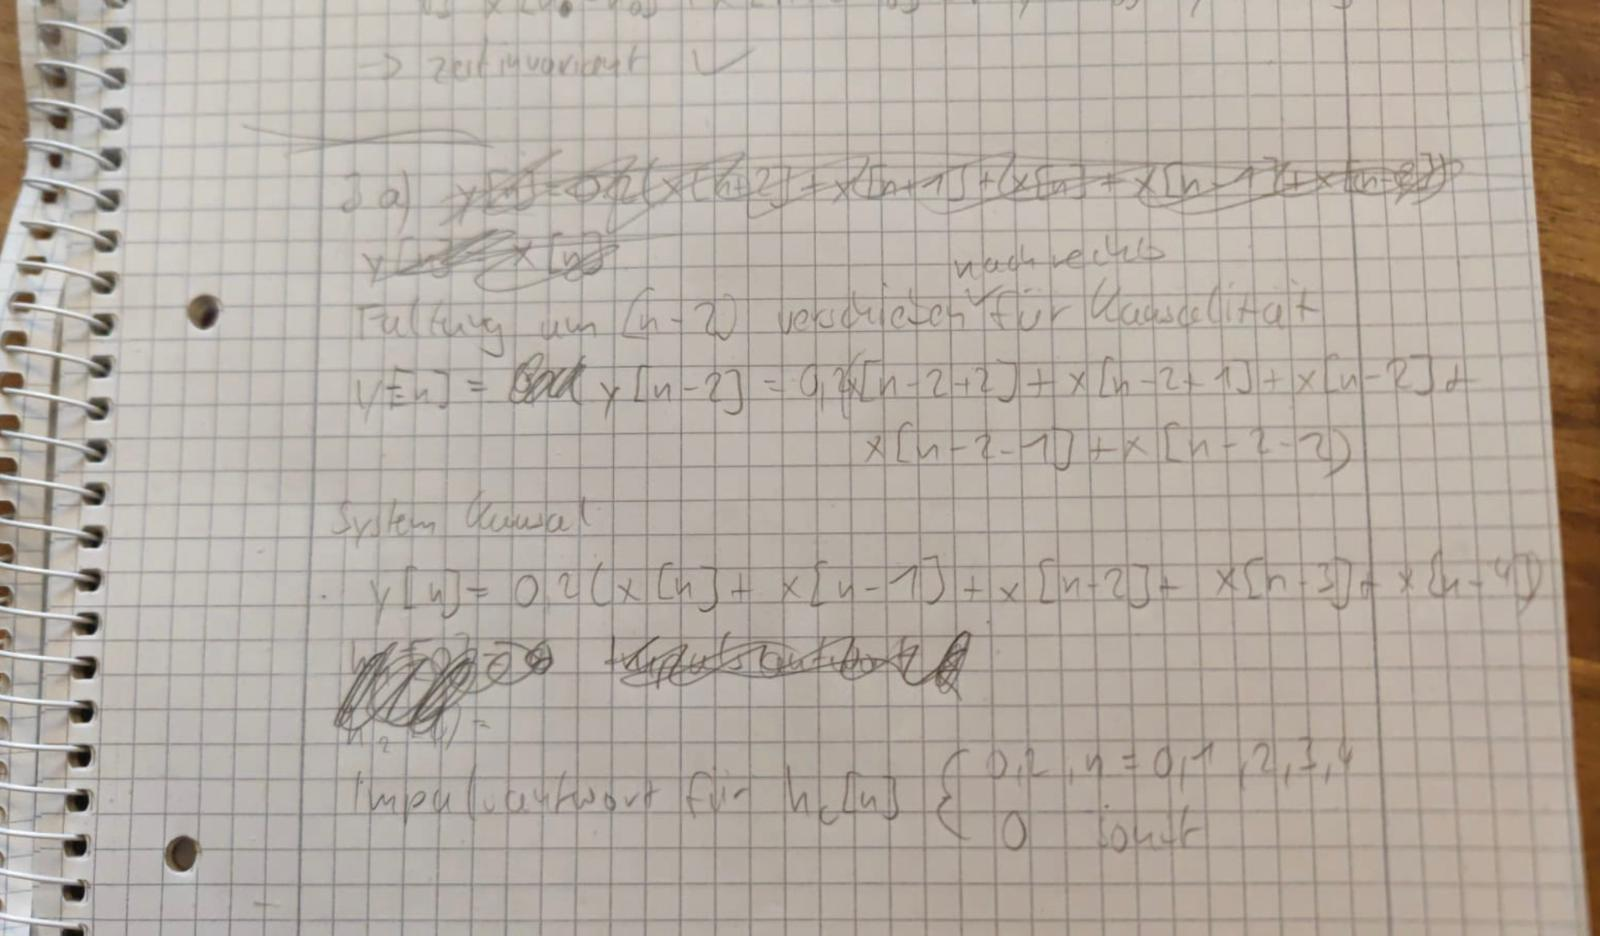

In [ ]:
def convolve_signals(a, b):
    a_length = len(a)
    b_length = len(b)
    y = 0
    ausgangSignal = []
    for n in range(a_length + b_length - 1):
        y = 0
        for k in range(b_length-1):
            if k>= n:
                y += b[k]*a[n-k]
        ausgangSignal.append(y)
    return ausgangSignal

a = [1, -1]
b = [2, 0 ,0, 1]
print(convolve_signals(a, b))



[0, 0, 0, 0, 0]


## 4

In [22]:
import numpy as np
import timeit
def rdft(x, fs):
    """
    Calculate the single-sided spectrum and corresponding frequency vector 
    using the real-valued time signal x and sampling frequency fs.
    
    Parameters:
    - x: Input time signal (1D array or list).
    - fs: Sampling frequency in Hz.
    
    Returns:
    - X: Single-sided spectrum (magnitude).
    - f: Corresponding frequency vector.
    """
    N = len(x)  # Length of the input signal
    X = np.zeros(N // 2 + 1, dtype=complex)  # Initialize spectrum array for positive frequencies

    # Compute DFT for positive frequencies
    for k in range(N // 2 + 1):
        for n in range(N):
            X[k] += x[n] * (np.cos(2 * np.pi * k * n / N) - 
                            1j * np.sin(2 * np.pi * k * n / N))
    
    # Calculate magnitude of the single-sided spectrum
    magnitude = np.abs(X)
    
    # Create frequency vector
    f = np.linspace(0, fs / 2, N // 2 + 1)

    return magnitude, f

N_values = [1024, 1025, 1026, 1027, 4096, 8192]
fs = 16000  # Sampling frequency

for N in N_values:
    print(f"Testing with N = {N}")
    
    # Generating a random noise signal
    x = np.random.rand(N)  # Use random noise as input
    
    # Computing using custom rdft
    X_rdft, f_rdft = rdft(x, fs)
    
    # Computing using NumPy's rfft and rfftfreq
    X_np = np.fft.rfft(x)
    f_np = np.fft.rfftfreq(N, d=1/fs)

    # a) Check if the results are similar
    try:
        np.testing.assert_allclose(X_rdft, X_np, rtol=1e-5, atol=1e-8)
        print("Results are similar.")
    except AssertionError as e:
        print("Results differ:", e)

    # b) Compare computation times
    rdft_time = timeit.timeit('rdft(x, fs)', number=5, globals={"rdft": rdft, "x": x, "fs": fs})
    np_fft_time = timeit.timeit('np.fft.rfft(x)', number=5, globals={"np": np, "x": x})
    
    print(f"rdft computation time: {rdft_time:.6f} seconds.")
    print(f"numpy.fft.rfft computation time: {np_fft_time:.6f} seconds.")
    print("-----")

Testing with N = 1024
Results differ: 
Not equal to tolerance rtol=1e-05, atol=1e-08

Mismatched elements: 512 / 513 (99.8%)
Max absolute difference among violations: 41.23282664
Max relative difference among violations: 2.
 ACTUAL: array([5.161699e+02, 8.871673e+00, 7.877283e+00, 1.109574e+01,
       8.866421e+00, 7.253068e+00, 1.184546e+01, 8.902959e+00,
       5.527456e+00, 1.222291e+01, 8.447722e+00, 1.066896e+01,...
 DESIRED: array([ 5.161699e+02 +0.j      ,  4.515715e+00 -7.636419j,
       -4.758455e+00 -6.277635j, -1.010205e+01 -4.589552j,
        4.746465e+00 +7.488959j,  5.528909e+00 +4.694482j,...
rdft computation time: 37.466933 seconds.
numpy.fft.rfft computation time: 0.000408 seconds.
-----
Testing with N = 1025
Results differ: 
Not equal to tolerance rtol=1e-05, atol=1e-08

Mismatched elements: 512 / 513 (99.8%)
Max absolute difference among violations: 43.95822695
Max relative difference among violations: 1.9999641
 ACTUAL: array([4.984059e+02, 4.458844e+00, 6.048427e+0

KeyboardInterrupt: 

In [20]:
 
import numpy as np

def rdft(x, fs):
    """
    Calculate the single-sided spectrum and corresponding frequency vector 
    using the real-valued time signal x and sampling frequency fs.
    
    Parameters:
    - x: Input time signal (1D array or list).
    - fs: Sampling frequency in Hz.
    
    Returns:
    - X: Single-sided spectrum (magnitude).
    - f: Corresponding frequency vector.
    """
    N = len(x)  # Length of the input signal
    X = np.zeros(N // 2 + 1, dtype=complex)  # Initialize spectrum array for positive frequencies

    # Compute DFT for positive frequencies
    for k in range(N // 2 + 1):
        for n in range(N):
            X[k] += x[n] * (np.cos(2 * np.pi * k * n / N) - 
                            1j * np.sin(2 * np.pi * k * n / N))
    
    # Calculate magnitude of the single-sided spectrum
    magnitude = np.abs(X)
    
    # Create frequency vector
    f = np.linspace(0, fs / 2, N // 2 + 1)

    return magnitude, f

 
import numpy as np

# Parameters
fs = 16000         # Sampling rate
N = 1024           # FFT length (also signal length here)
t = np.arange(N) / fs  # Time vector

# Example signal: a combination of two sine waves
x = 0.7 * np.sin(2 * np.pi * 1000 * t) + 0.3 * np.sin(2 * np.pi * 3500 * t)

# Optional window (Hanning window for spectral leakage reduction)
win = np.hanning(N)  # You can use np.ones(N) for no window.
xw = x * win        # Apply the window to the signal

# FFT and frequency vector
X = np.fft.rfft(xw)  # Compute the real FFT of the windowed signal
f = np.fft.rfftfreq(N, d=1/fs)  # Computes the frequency bins

# Amplitude normalization & window correction
cg = np.sum(win) / N          # Coherent gain of the window
X = X / (N * cg)              # Scale so amplitudes correspond to signal amplitude

# Convert to single-sided amplitude spectrum
if N % 2 == 0:
    X[1:-1] *= 2  # Double the values for the non-DC and non-Nyquist components
else:
    X[1:] *= 2  # Double the values for the non-DC components

# Compute the magnitude spectrum
mag = np.abs(X) 

# Optional: Print the magnitude spectrum and frequency values for verification
print("Frequency bins (Hz):", f)
print("Magnitude spectrum:", mag)

y, f = rdft(x, fs)

# np.testing.assert_allclose(X, y)
# np.testing.assert_allclose(f_np, f)


Frequency bins (Hz): [   0.      15.625   31.25    46.875   62.5     78.125   93.75   109.375
  125.     140.625  156.25   171.875  187.5    203.125  218.75   234.375
  250.     265.625  281.25   296.875  312.5    328.125  343.75   359.375
  375.     390.625  406.25   421.875  437.5    453.125  468.75   484.375
  500.     515.625  531.25   546.875  562.5    578.125  593.75   609.375
  625.     640.625  656.25   671.875  687.5    703.125  718.75   734.375
  750.     765.625  781.25   796.875  812.5    828.125  843.75   859.375
  875.     890.625  906.25   921.875  937.5    953.125  968.75   984.375
 1000.    1015.625 1031.25  1046.875 1062.5   1078.125 1093.75  1109.375
 1125.    1140.625 1156.25  1171.875 1187.5   1203.125 1218.75  1234.375
 1250.    1265.625 1281.25  1296.875 1312.5   1328.125 1343.75  1359.375
 1375.    1390.625 1406.25  1421.875 1437.5   1453.125 1468.75  1484.375
 1500.    1515.625 1531.25  1546.875 1562.5   1578.125 1593.75  1609.375
 1625.    1640.625 1656.25  16

## 5

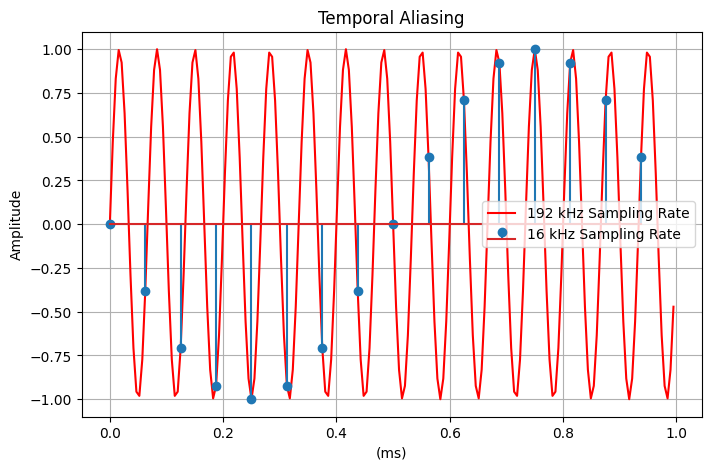

In [12]:
 
import numpy as np
import matplotlib.pyplot as plt

# Constants
frequency = 15000  # 15 kHz
t = np.linspace(0, 0.001, 1000)  # time vector for 1 millisecond

# High sampling rate (192 kHz)
sampling_rate_high = 192000  # 192 kHz
t_high = np.arange(0, 0.001, 1/sampling_rate_high)
signal_high = np.sin(2 * np.pi * frequency * t_high)

# Low sampling rate (16 kHz)
sampling_rate_low = 16000  # 16 kHz
t_low = np.arange(0, 0.001, 1/sampling_rate_low)
signal_low = np.sin(2 * np.pi * frequency * t_low)

plt.figure(figsize=(8, 5))
plt.plot(t_high * 1000, signal_high, color='red', label='192 kHz Sampling Rate')
plt.stem(t_low * 1000, signal_low, label='16 kHz Sampling Rate')
plt.grid(True)

plt.title('Temporal Aliasing')
plt.xlabel("(ms)")
plt.ylabel("Amplitude")
plt.legend()

plt.show()

# According to Nyquist theorem, we need at least twice the sampling rate to sample 
# a continuous signal without losing information.  
# In this case, the lower sampling rate (16 kHz) does not fulfill this theorem, 
# which is why between two samples of the lower sampling rates you can see a full cycle
# of the original sine signal (thanks to the high sampling rate of 192 kHz).